In [2]:
import requests
import pandas as pd
import io
import datetime as dt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.display import JSON
#import seaborn as sns
#sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os

In [3]:
csv = requests.get("https://opendata.arcgis.com/datasets/37abda537d17458bae6677b8ab75fcb9_0.csv").content
main_df = pd.read_csv(io.StringIO(csv.decode('utf-8')))

1. Filtering out "Hospitalizations"

In [27]:
filt = main_df["Hospitalized"] == "YES"
df = main_df[filt]

In [16]:
# Trying to save the data to a csv
# df = df[['County','Age',"Age_group","Gender","Jurisdiction","Travel_related","Hospitalized","Died","CaseDate"]]
# filepath = "../Resources/cleaned_csv.csv"
# df.to_csv(filepath)

In [7]:
#df

2. Changing 'EventDate' to more manageable structure

In [11]:
# Splitting dates
#df.Case1 = df.loc[:,"Case1"].str.split()
#df.Case1 = df.Case1.map(lambda x: x[0])
#df.rename(columns = {"Case1":"CaseDate"},inplace=True)

In [8]:
# First Run through
#df.loc[:,'EventDate'] = pd.to_datetime(df.loc[:,'EventDate'],format='%Y/%m/%d %H:%M:%S')
#df.loc[:,"FormattedEventDate"] = df.loc[:,"EventDate"].dt.strftime("%m/%d/%Y")
#df.loc[:,"EventDate"] = pd.to_datetime(df.loc[:,"FormattedEventDate"],format='%m/%d/%Y')
#df = df.iloc[:,[0,1,2,3,7,8,9,13,16]]

In [28]:
df.loc[:,'Case1'] = pd.to_datetime(df.loc[:,'Case1'],format='%Y/%m/%d %H:%M:%S')
df.loc[:,"FormattedCase1"] = df.loc[:,"Case1"].dt.strftime("%m/%d/%Y")
df.loc[:,"Case1"] = pd.to_datetime(df.loc[:,"FormattedCase1"],format='%m/%d/%Y')
df = df.iloc[:,[0,1,2,3,7,8,9,13,16]]

In [19]:
df.columns

Index(['County', 'Age', 'Age_group', 'Gender', 'EDvisit', 'Hospitalized',
       'Died', 'EventDate', 'FormattedCase1'],
      dtype='object')

In [20]:
df.head(3)

,County,Age,Age_group,Gender,EDvisit,Hospitalized,Died,EventDate,FormattedCase1
5,Dade,56.0,55-64 years,Male,YES,YES,NaN,2020/04/03 00:00:00+00,04/06/2020
10,Indian River,81.0,75-84 years,Male,YES,YES,NaN,2020/04/22 00:00:00+00,04/22/2020
11,Broward,61.0,55-64 years,Female,UNKNOWN,YES,NaN,2020/03/09 00:00:00+00,04/06/2020


In [8]:
dtype()


NameError: name 'dtype' is not defined

In [9]:
hospitalized_df = df.groupby("FormattedCase1").count().reset_index()[['FormattedCase1','Hospitalized']]
df.groupby("FormattedCase1").count()['Hospitalized'].tail(20)

FormattedCase1
06/27/2020    331
06/28/2020    256
06/29/2020    310
06/30/2020    233
07/01/2020    426
07/02/2020    350
07/03/2020    257
07/04/2020    219
07/05/2020    171
07/06/2020    360
07/07/2020    315
07/08/2020    248
07/09/2020    343
07/10/2020    247
07/11/2020    132
07/12/2020    210
07/13/2020    210
07/14/2020    195
07/15/2020     96
07/16/2020     48
Name: Hospitalized, dtype: int64

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(hospitalized_df['FormattedCase1'],hospitalized_df["Hospitalized"])
ax.xaxis.set_major_formatter(DateFormatter("%m/%d"))
ax.xaxis_date()
plt.title(label="New Hospitalizations in Florida")
plt.xlim(left=plt.xlim()[1]-99,right=plt.xlim()[1]-9)

(39.60813172043012, 129.60813172043012)

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'UnitData'

## Hypothesis Testing
-------------

In [75]:
day_delta = 14
opening_date = dt.datetime(2020,5,4) + dt.timedelta(days=6)
d_before = opening_date - dt.timedelta(days=day_delta)
d_after = opening_date + dt.timedelta(days=day_delta)
filt_before = ((df["EventDate"]>=d_before) & (df["EventDate"] < opening_date))
before_df = df[filt_before]
filt_after = ((df["EventDate"]>opening_date) & (df["EventDate"] <= d_after))
after_df = df[filt_after]

grouped_before = before_df.groupby("EventDate").count().reset_index()[['EventDate','Hospitalized']]
grouped_after = after_df.groupby("EventDate").count().reset_index()[['EventDate','Hospitalized']]

Ttest_indResult(statistic=-0.48635165455900886, pvalue=0.6307922218061446)

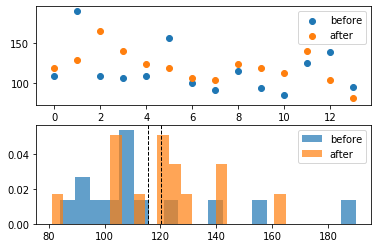

In [76]:
# Generate some fake data to test with
def gendata(loc=0):
    sample1 = grouped_before['Hospitalized']
    sample2 = grouped_after['Hospitalized']

    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(sample1)), sample1, label="before")
    plt.scatter(range(len(sample2)), sample2, label="after")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(sample1, 20, density=True, alpha=0.7, label="before")
    plt.hist(sample2, 20, density=True, alpha=0.7, label="after")
    plt.axvline(sample1.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(sample2.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()  
    
    return sample1, sample2

sample1, sample2 = gendata()
stats.ttest_ind_from_stats(grouped_before["Hospitalized"].mean(),grouped_before["Hospitalized"].std(),grouped_before["Hospitalized"].size,grouped_after["Hospitalized"].mean(),grouped_after["Hospitalized"].std(),grouped_after["Hospitalized"].size)

In [79]:
grouped_after["Hospitalized"].describe()

count     14.000000
mean     120.214286
std       20.081291
min       81.000000
25%      107.500000
50%      119.000000
75%      127.000000
max      165.000000
Name: Hospitalized, dtype: float64

In [78]:
grouped_before["Hospitalized"].describe()

count     14.000000
mean     115.642857
std       28.872684
min       84.000000
25%       96.250000
50%      108.000000
75%      122.500000
max      190.000000
Name: Hospitalized, dtype: float64